# 1. import script

In [1]:
import sys
import pickle
import torch

# Add the file path to sys.path
sys.path.append(r'D:/master_new/scripts')

# Import functions and classes from custom modules
from data_utils import (
    align_audio_mesh, extract_mouth_indices, crop_to_mouth,
    compute_pca, encode_to_pca, standardize_pca_codes,
    build_loaders
)

from RNN_train import (
    LipsyncRNN, train_model, evaluate_on_testset, plot_loss_curve
)

# 2.Process data

In [2]:
#1. Align Δmesh and save 

align_audio_mesh(
    data_verts_path='D:/master_new/trainningdata/data_verts.npy',
    audio_pkl_path='D:/master_new/trainningdata/processed_audio_deepspeech.pkl',
    idx_map_path='D:/master_new/trainningdata/subj_seq_to_idx.pkl',
    template_path='D:/master_new/trainningdata/templates.pkl',##Mesh template for each subject (static reference frame)
    output_path='Unnormalized_lipsync_dmesh.pkl'
)
#Output: pickle file containing audio, dmesh and name.

#2. Extract the mouth vertex index (only need to be done once)

extract_mouth_indices(
    template_ply_path=r"D:\voice\registereddata\FaceTalk_170725_00137_TA\sentence01\sentence01.000001.ply",#A standard PLY file for extracting the vertex index of the mouth
    save_path='mouth_indices.npy'
)

#3. Cut out the mouth Δmesh and save it

crop_to_mouth(
    dmesh_path='Unnormalized_lipsync_dmesh.pkl',
    mouth_idx_path='mouth_indices.npy',
    output_path='Unnorm_lipsync_mouth_only.pkl'
)


Aligning data: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]


✅ Mouth vertices: 508


In [3]:
import pickle

# set path
mouth_dmesh_path = 'Unnorm_lipsync_mouth_only.pkl'
pca_dir = 'pca_output'
scaler_path = f'{pca_dir}/scaler.pkl'

# Load the cropped data
with open(mouth_dmesh_path, 'rb') as f:
    data = pickle.load(f)
audio_list = data['audio']
dmesh_list = data['dmesh_mouth']

# run PCA
pca_model = compute_pca(dmesh_list, save_dir=pca_dir, var_threshold=0.99)

# PCA
code_list = encode_to_pca(dmesh_list, pca_model)

# Standardize encoding
scaled_code_list = standardize_pca_codes(code_list, scaler_path)

# Build loader
train_loader, val_loader, test_loader = build_loaders(audio_list, scaled_code_list)

# Test sample dimensions
x, y = next(iter(train_loader))
print(f"✅ Train dataset size: {len(train_loader.dataset)}")
print(f"Batch shapes: audio = {x.shape}, code = {y.shape}")


✅ Train dataset size: 19447
Batch shapes: audio = torch.Size([16, 30, 464]), code = torch.Size([16, 30, 31])


# 3.train model

Epoch 1/100 - Train Loss: 1.0197 - Val Loss: 0.9771
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9771)
Epoch 2/100 - Train Loss: 1.0116 - Val Loss: 0.9706
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9706)
Epoch 3/100 - Train Loss: 1.0047 - Val Loss: 0.9650
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9650)
Epoch 4/100 - Train Loss: 0.9990 - Val Loss: 0.9609
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9609)
Epoch 5/100 - Train Loss: 0.9945 - Val Loss: 0.9576
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9576)
Epoch 6/100 - Train Loss: 0.9905 - Val Loss: 0.9546
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9546)
Epoch 7/100 - Train Loss: 0.9870 - Val Loss: 0.9521
✅ Validation loss decreased, model saved to best_model_rnn.pt (val_loss=0.9521)
Epoch 8/100 - Train Loss: 0.9839 - Val Loss: 0.9498
✅ Validation loss decrea

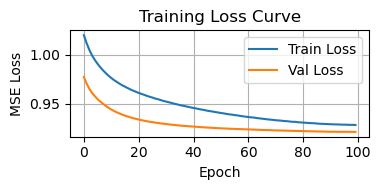

Evaluating: 100%|██████████| 29/29 [00:00<00:00, 582.00it/s]


📊 Assessment results:
✅ MSE:              0.9685
✅ MAE:              0.7762
✅ Cosine Similarity:0.2666
✅ Smoothness:       0.0030


In [4]:
import torch.optim as optim

model = LipsyncRNN(dropout=0.2, max_seq_len=30).to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=100,
    patience=20,
    save_path='best_model_rnn.pt',
    initial_lr=1e-5   # 设置初始学习率
)

#Training visualization
plot_loss_curve(train_losses, val_losses)

# Test set evaluation
model.load_state_dict(torch.load('best_model_rnn.pt'))
metrics = evaluate_on_testset(model, test_loader)

# 4.Visualization

In [5]:
import numpy as np
import joblib

# 1. Load model prediction output (PCA code or standardized PCA code)
pred_code = np.load('output_expr_rnn_eval/predicted_expr.npy')  # shape = (T, 31)

pred_code = pred_code[0]

# 2. If you StandardScale the PCA code during training, then de-standardize it
scaler = joblib.load('D:/master_new/trainningdata/pca/code_scaler.pkl')
# a) If the predicted output is the "standardized" code, use inverse_transform
raw_code = scaler.inverse_transform(pred_code)            # → (T, 31)
# b) If the prediction output itself is the "raw PCA code", then directly:
# raw_code = pred_code

# 3. Load PCA results (components and mean)
components = np.load('D:/master_new/trainningdata/pca_components.npy')  # (31, 1413)
mean_vec   = np.load('D:/master_new/trainningdata/pca_mean.npy')        # (1413,)

# 4. Decode PCA code back to flatten Δmesh
# raw_code @ components Restore to zero-centered PCA space, then add mean_vec
recon_flat = raw_code @ components + mean_vec                         # (T, 1413)

# 5. Reshape back to 3D form of Δmesh
recon_dmesh = recon_flat.reshape(-1, 508, 3)                           # (T, 471, 3)

# 6. Verify
print("Decoded Δmesh shape:", recon_dmesh.shape)  #  (T, 471, 3)

Decoded Δmesh shape: (30, 508, 3)


In [6]:
import numpy as np
import trimesh

# 1. Load the template full face vertices
template = trimesh.load(r"D:\voice\registereddata\FaceTalk_170725_00137_TA\sentence01\sentence01.000001.ply",
                        process=False)
verts = template.vertices  # (5023, 3)

# 2. Load the mouth Δmesh and the corresponding index
recon = recon_dmesh        # (30, 471, 3)
mouth_idx = np.load("mouth_indices.npy")   # (471,)

# 3. Overlay deformation, only take the mouth vertices
mouth_pts = verts[mouth_idx] + recon       # (30, 471, 3)


gt = next(iter(train_loader))
gt = gt[1][0]
#gt.shape
gt = scaler.inverse_transform(gt) 
gt_recon_flat = gt @ components + mean_vec
gt_recon_dmesh = gt_recon_flat.reshape(-1, 508, 3) 


#visualization
pred_full_dmesh = np.zeros((recon.shape[0], verts.shape[0], 3))  # (30, 5023, 3)
pred_full_dmesh[:, mouth_idx, :] = recon  # Replace the mouth area with the predicted Δmesh

# Add static face to get complete facial animation
pred_full_face = verts[None, :, :] + pred_full_dmesh  # shape: (30, 5023, 3)


gt_full_dmesh = np.zeros((gt_recon_dmesh.shape[0], verts.shape[0], 3))  # (30, 5023, 3)
gt_full_dmesh[:, mouth_idx, :] = gt_recon_dmesh  # Replace the mouth area with the real Δmesh

# Add static face to get complete facial animation
gt_full_face = verts[None, :, :] + gt_full_dmesh  # shape: (30, 5023, 3)


In [7]:
gt = next(iter(train_loader))
gt = gt[1][0]
#gt.shape
gt = scaler.inverse_transform(gt) 
gt_recon_flat = gt @ components + mean_vec
gt_recon_dmesh = gt_recon_flat.reshape(-1, 508, 3) 

gt_mouth_pts = verts[mouth_idx] + gt_recon_dmesh

In [8]:
def animate_pointcloud(verts, num_frames=30, interval=100,
                       zoom=1,            
                       elev=-90, azim=90,
                       point_size=0.3):      

    import numpy as np, matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import animation

    if isinstance(verts, (list, tuple)):
        verts = np.stack(verts, axis=0)

    verts = verts * zoom

    fig = plt.figure(figsize=(5, 5))        
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter([], [], [], s=point_size)

    ax.set_axis_off()

    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([-0.1, 0.1])
    ax.view_init(elev=elev, azim=azim)

    def update(i):
        v = verts[i]
        scat._offsets3d = (v[:, 0], v[:, 1], v[:, 2])
        ax.set_title(f"Frame {i}")
        return scat,

    ani = animation.FuncAnimation(fig, update,
                                  frames=min(num_frames, len(verts)),
                                  interval=interval, blit=False)
    plt.close()
    return ani

In [10]:
#realanimation
ani_pred = animate_pointcloud(gt_full_face, num_frames=30, zoom=1)

from IPython.display import HTML
display(HTML(ani_pred.to_jshtml()))

In [9]:
#predicted animation
ani_pred = animate_pointcloud(pred_full_face, num_frames=30, zoom=1)

from IPython.display import HTML
display(HTML(ani_pred.to_jshtml()))